In [1]:
#-*- coding:utf-8 -*-

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans

from sklearn.utils.testing import ignore_warnings
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import *
from sklearn.cluster import *

from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from operator import itemgetter
from operator import attrgetter

from pyjarowinkler import distance
from collections import Counter

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import nltk

import math
import time

import csv
import sys

import re
import io
import os

start_time = time.time()

def remove_string_special_characters(s):
    
    stripped = re.sub('[^a-zA-z\s]', '', s)
    
    stripped = re.sub('_', '', stripped)
    
    stripped = re.sub('\s+', ' ', stripped)
    
    stripped = stripped.strip()
    
    if stripped != '':
        return stripped.lower()
    
def multisort(xs, specs):
    
    for key, reverse in reversed(specs):
        
        xs.sort(key=attrgetter(key), reverse=reverse)
        
    return xs

def uniq_list(input):
    output = []
    for x in input:
        if x not in output:
            output.append(x)
    return output

def extractive_keyword(path,database_update_path,extract_word_num=20):
    
    reviewee = pd.read_csv(path, encoding='latin1')
    count,temp = len(reviewee),[]

    for i in range(count):
        
        temp_intro = reviewee['submitter_intro'][i]

        textrank_text = ''

        for c in (keywords(temp_intro, words=extract_word_num, lemmatize=True).split('\n')):
            
            textrank_text += (c+ " ")

        temp.append(textrank_text)

    reviewee['submitter_attribute']=temp
    
    #return type : pandas.dataframe
    return reviewee

reviewee=extractive_keyword(path='../reviewee/submitter_10.csv',
                                database_update_path='../../reviewee/sybmitter_update_100.csv',
                                extract_word_num=20)
reviewee[:3]

/root/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


,date,submitter_orcid,submitter_name,submitter_institution,submitter_email,submitter_title_doi,submitter_title,submitter_intro,submitter_author1_name,submitter_author1_institution,...,submitter_author8_name,submitter_author8_institution,submitter_author8_email,submitter_author9_name,submitter_author9_institution,submitter_author9_email,submitter_author10_name,submitter_author10_institution,submitter_author10_email,submitter_attribute
0,20200101,326,Lu Qin,"The Chinese University of Hong Kong, Hong Kong...",lqin@se.cuhk.edu.hk,NaN,Diversifying Top-K Results,ABSTRACT This paper proposes a general framewo...,Lu Qin,"The Chinese University of Hong Kong, Hong Kong...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distance similarities match sequences subseque...
1,20200102,897,Haohan Zhu,Department of Computer Science Boston University,zhu@cs.bu.edu,NaN,A Generic Framework for Efficient and Effectiv...,ABSTRACT Top-k query processing finds a list o...,Haohan Zhu,Department of Computer Science Boston University,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,result algorithms searches problems solution b...
2,20200103,1387,Stefan Aulbach,"Technische Universit?t M?nchen, Germany",stefan.aulbach@in.tum.de,NaN,A Comparison of Flexible Schemas for Software ...,ABSTRACT A multi-tenant database system for So...,Stefan Aulbach,"Technische Universit?t M?nchen, Germany",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,table column mappings tenants performing queri...


In [2]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import AgglomerativeClustering
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")

In [3]:

def professionalism(path,extractive_keyword_result,reviewee_index,top_limit,silhouette_range=25):
    
    #인자 전달
    reviewee,index,top=extractive_keyword_result,reviewee_index,top_limit
    temp_id,temp_doi = 0,''
    
    #투고 원고 열 정보 추출
    temp_title = reviewee.loc[index]['submitter_title']
    temp_attribure = reviewee.loc[index]['submitter_attribute']
    
    # 심사자풀 Read
    reviewer_attr = pd.read_csv(path, encoding='latin1')
    
    # 투고원고 dataframe 맨 윗줄 추가
    reviewer_attr.loc[-1] = [str(temp_id),temp_doi,temp_title,temp_attribure]
    reviewer_attr.index += 1
    reviewer_attr.sort_index(inplace=True)
    reviewer = reviewer_attr['reviewer_paper_attribure']
    
    # 속성집합 20개 제한
    reviewer_attribute=[]
    for i in range(len(reviewer)):
        a=((reviewer[i]).split(' '))
        b=a[:20]
        temp=[]
        for j in range(20):
            temp.append(b[j])
            temp += (str(b[j]) + ',')
        reviewer_attribute.append(temp[:-1])
    
    common_texts_and_tags = [
        (text, [f"str_{i}",]) for i, text in enumerate(reviewer_attribute)
    ]
    
    TRAIN_documents = [TaggedDocument(words=text, tags=tags) for text, tags in common_texts_and_tags]
    
    model = Doc2Vec(TRAIN_documents)#, vector_size=5, window=3, epochs=40, min_count=0, workers=4) #Accessing Document vector
    
#     for text, tags in common_texts_and_tags:
#         trained_doc_vec = model.docvecs[tags[0]]
#         inferred_doc_vec = model.infer_vector(text)
#         print(f"tags: {tags}, text: {text}")
#     #     print(f"trained_doc_vec: {trained_doc_vec}")
#         print(f"vec: {inferred_doc_vec}")
#         print("---"*20)
#     print(model)
#     dtm_df=[]
#     for text, tags in common_texts_and_tags:

# #         trained_doc_vec = model.docvecs[tags[0]]
#         inferred_doc_vec = model.infer_vector(text)
        
#         dtm_df_temp=[]
#         for text2, tag2s in common_texts_and_tags:

#             inferred_doc_vec = model.infer_vector(text2)

#             sim = word_vectors.wmdistance(text, text2)

#             dtm_df_temp.append(sim)
#         dtm_df.append(dtm_df_temp)
        
#     dissim_df = pd.DataFrame(data=dtm_df)
#     dissimilarity=dissim_df.values

#     model1 = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
#     model1.fit(dissimilarity)
#     labels1 = model1.labels_
#     dissim_df['cluster']=labels1
    
#     display(dissim_df)
#     dissim_df.to_csv('./dissim_df_0905.csv')
    
#     #return type : pandas.dataframe
#     return dissim_df

#전문성검사
#키워드 매개변수(입력csv path, 투고원고 DataFrame, i번째 투고 원고, 추천할 심사자 수, 실루엣값 계산 범위 지정)
i=0
print(str(i)+'번째')
aaa = professionalism(path='./reviewer_attribute_937.csv',
                     extractive_keyword_result=reviewee,
                     reviewee_index=i,
                     top_limit=10,
                     silhouette_range=25)
#return type : pandas.dataframe

# reviewer


0번째


---

In [6]:
aaa = pd.read_csv('./dissim_df_0905_2.csv', encoding='latin1',index_col=0)
aaa

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,936,937,cluster
0,0.000000,1.665847,1.357595,1.530824,1.263174,1.573965,1.307275,1.632034,1.212934,1.702639,...,1.277255,1.350370,1.551739,1.460266,1.541761,1.831157,1.602758,1.349115,1.513797,6
1,1.665847,0.000000,1.430854,1.271745,1.626433,1.540329,1.388308,1.282496,1.405854,1.419545,...,1.466218,1.556161,1.524717,1.573841,1.661901,1.940531,1.328991,1.670690,1.717372,5
2,1.357595,1.430854,0.000000,1.219101,1.490985,1.762304,1.419445,1.240686,1.398092,1.455259,...,1.389531,1.260215,1.456952,1.264608,1.514247,1.748988,1.511831,1.589297,1.636413,5
3,1.530824,1.271745,1.219101,0.000000,1.551202,1.478244,1.155090,1.125819,1.274079,1.193266,...,1.307754,1.205408,1.316317,1.168999,1.558632,1.683721,1.259141,1.574794,1.603381,3
4,1.263174,1.626433,1.490985,1.551202,0.000000,1.284324,1.405420,1.598640,1.226232,1.640499,...,1.320181,1.565053,1.407803,1.579730,1.185100,1.473322,1.636903,1.355975,1.117593,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,1.541761,1.661901,1.514247,1.558632,1.185100,1.300700,1.522435,1.633116,1.531974,1.653401,...,1.569100,1.523864,1.327388,1.694451,0.000000,1.363316,1.754948,1.372821,1.432512,0
934,1.831157,1.940531,1.748988,1.683721,1.473322,1.253591,1.747096,1.883207,1.745724,1.664263,...,1.696761,1.642744,1.538109,1.832155,1.363316,0.000000,1.738734,1.556909,1.581600,0
935,1.602758,1.328991,1.511831,1.259141,1.636903,1.460452,1.274698,1.347854,1.411387,1.253849,...,1.441316,1.279254,1.501100,1.433937,1.754948,1.738734,0.000000,1.726434,1.638411,5
936,1.349115,1.670690,1.589297,1.574794,1.355975,1.393094,1.547457,1.424872,1.446616,1.644607,...,1.337651,1.375300,1.450624,1.533906,1.372821,1.556909,1.726434,0.000000,1.357351,0


In [7]:
asdf = []
for i in range(938):
    qwer = 'Manuscript ' + str(i)
    asdf.append(qwer)


In [8]:
aaa1=aaa.iloc[:,:-1]
aaa1

,0,1,2,3,4,5,6,7,8,9,...,928,929,930,931,932,933,934,935,936,937
0,0.000000,1.665847,1.357595,1.530824,1.263174,1.573965,1.307275,1.632034,1.212934,1.702639,...,1.680791,1.277255,1.350370,1.551739,1.460266,1.541761,1.831157,1.602758,1.349115,1.513797
1,1.665847,0.000000,1.430854,1.271745,1.626433,1.540329,1.388308,1.282496,1.405854,1.419545,...,1.343414,1.466218,1.556161,1.524717,1.573841,1.661901,1.940531,1.328991,1.670690,1.717372
2,1.357595,1.430854,0.000000,1.219101,1.490985,1.762304,1.419445,1.240686,1.398092,1.455259,...,1.354854,1.389531,1.260215,1.456952,1.264608,1.514247,1.748988,1.511831,1.589297,1.636413
3,1.530824,1.271745,1.219101,0.000000,1.551202,1.478244,1.155090,1.125819,1.274079,1.193266,...,1.314718,1.307754,1.205408,1.316317,1.168999,1.558632,1.683721,1.259141,1.574794,1.603381
4,1.263174,1.626433,1.490985,1.551202,0.000000,1.284324,1.405420,1.598640,1.226232,1.640499,...,1.718594,1.320181,1.565053,1.407803,1.579730,1.185100,1.473322,1.636903,1.355975,1.117593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,1.541761,1.661901,1.514247,1.558632,1.185100,1.300700,1.522435,1.633116,1.531974,1.653401,...,1.647365,1.569100,1.523864,1.327388,1.694451,0.000000,1.363316,1.754948,1.372821,1.432512
934,1.831157,1.940531,1.748988,1.683721,1.473322,1.253591,1.747096,1.883207,1.745724,1.664263,...,1.655348,1.696761,1.642744,1.538109,1.832155,1.363316,0.000000,1.738734,1.556909,1.581600
935,1.602758,1.328991,1.511831,1.259141,1.636903,1.460452,1.274698,1.347854,1.411387,1.253849,...,1.448417,1.441316,1.279254,1.501100,1.433937,1.754948,1.738734,0.000000,1.726434,1.638411
936,1.349115,1.670690,1.589297,1.574794,1.355975,1.393094,1.547457,1.424872,1.446616,1.644607,...,1.550830,1.337651,1.375300,1.450624,1.533906,1.372821,1.556909,1.726434,0.000000,1.357351


In [9]:
aaa2=aaa1.values

In [10]:
aaa_df=pd.DataFrame(data=aaa2,index=asdf,columns=asdf)
aaa_df

,Manuscript 0,Manuscript 1,Manuscript 2,Manuscript 3,Manuscript 4,Manuscript 5,Manuscript 6,Manuscript 7,Manuscript 8,Manuscript 9,...,Manuscript 928,Manuscript 929,Manuscript 930,Manuscript 931,Manuscript 932,Manuscript 933,Manuscript 934,Manuscript 935,Manuscript 936,Manuscript 937
Manuscript 0,0.000000,1.665847,1.357595,1.530824,1.263174,1.573965,1.307275,1.632034,1.212934,1.702639,...,1.680791,1.277255,1.350370,1.551739,1.460266,1.541761,1.831157,1.602758,1.349115,1.513797
Manuscript 1,1.665847,0.000000,1.430854,1.271745,1.626433,1.540329,1.388308,1.282496,1.405854,1.419545,...,1.343414,1.466218,1.556161,1.524717,1.573841,1.661901,1.940531,1.328991,1.670690,1.717372
Manuscript 2,1.357595,1.430854,0.000000,1.219101,1.490985,1.762304,1.419445,1.240686,1.398092,1.455259,...,1.354854,1.389531,1.260215,1.456952,1.264608,1.514247,1.748988,1.511831,1.589297,1.636413
Manuscript 3,1.530824,1.271745,1.219101,0.000000,1.551202,1.478244,1.155090,1.125819,1.274079,1.193266,...,1.314718,1.307754,1.205408,1.316317,1.168999,1.558632,1.683721,1.259141,1.574794,1.603381
Manuscript 4,1.263174,1.626433,1.490985,1.551202,0.000000,1.284324,1.405420,1.598640,1.226232,1.640499,...,1.718594,1.320181,1.565053,1.407803,1.579730,1.185100,1.473322,1.636903,1.355975,1.117593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Manuscript 933,1.541761,1.661901,1.514247,1.558632,1.185100,1.300700,1.522435,1.633116,1.531974,1.653401,...,1.647365,1.569100,1.523864,1.327388,1.694451,0.000000,1.363316,1.754948,1.372821,1.432512
Manuscript 934,1.831157,1.940531,1.748988,1.683721,1.473322,1.253591,1.747096,1.883207,1.745724,1.664263,...,1.655348,1.696761,1.642744,1.538109,1.832155,1.363316,0.000000,1.738734,1.556909,1.581600
Manuscript 935,1.602758,1.328991,1.511831,1.259141,1.636903,1.460452,1.274698,1.347854,1.411387,1.253849,...,1.448417,1.441316,1.279254,1.501100,1.433937,1.754948,1.738734,0.000000,1.726434,1.638411
Manuscript 936,1.349115,1.670690,1.589297,1.574794,1.355975,1.393094,1.547457,1.424872,1.446616,1.644607,...,1.550830,1.337651,1.375300,1.450624,1.533906,1.372821,1.556909,1.726434,0.000000,1.357351


In [11]:

reviewer_title = pd.read_csv('./reviewer_attribute_937.csv', encoding='latin1')
reviewer_title2 = reviewer_title['reviewer_title']
reviewer_title3=reviewer_title2.to_list()
reviewer_title3.insert(0,reviewee['submitter_title'][0])

In [12]:
aaa1=aaa.values

In [13]:
model1 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model1.fit(aaa1)
labels1 = model1.labels_

In [14]:
model2 = KMeans(n_clusters=5)
model2.fit(aaa1)
labels2 = model2.labels_

In [15]:
from sklearn.metrics.pairwise import euclidean_distances
# a0=aaa.iloc[:,:].to_list()
a1=aaa.iloc[0,:]
a11=[a1.to_list()]
a2=aaa.iloc[1,:]
a22=[a2.to_list()]


In [16]:
a=euclidean_distances(a11,a22)
a[0][0]

6.996813004971261

In [ ]:
temp1=[]
for i in range(0,938):
    temp2=[]
    a1=[(aaa.iloc[i,:]).to_list()]
    for j in range(0, 938):
        a2=[(aaa.iloc[j,:]).to_list()]
        a3=(euclidean_distances(a1,a2))[0][0]
        temp2.append(a3)
    temp1.append(temp2)


df_00=pd.DataFrame(temp1)

df_00

df_00.to_csv('./dissim_matrix.csv')

In [18]:
df_00= pd.read_csv('./dissim_matrix.csv', encoding='latin1',index_col=0)
df_00

,0,1,2,3,4,5,6,7,8,9,...,928,929,930,931,932,933,934,935,936,937
0,0.000000,30.840664,31.140950,33.788671,27.904755,34.943434,32.002540,30.244163,33.509446,34.456812,...,33.457130,33.868054,29.752157,34.164765,30.917000,3.409761e+01,34.847322,31.013345,29.775003,31.669085
1,30.840664,0.000000,30.989885,32.491282,29.503652,33.523814,31.332104,27.986370,32.270176,32.910757,...,32.211672,32.923638,29.261822,33.216510,29.231696,3.190428e+01,33.594571,30.651748,29.636880,30.448822
2,31.140950,30.989885,0.000000,33.482283,31.264828,34.862844,32.982509,28.529387,34.495498,34.429121,...,33.210720,34.371446,30.944483,34.307270,31.378951,3.305792e+01,33.414801,31.943803,31.235087,32.028395
3,33.788671,32.491282,33.482283,0.000000,33.121481,35.834208,32.602642,30.720627,35.042554,35.804861,...,35.187550,34.567832,32.106937,35.792270,32.608901,3.597806e+01,35.289884,33.211841,32.552964,33.246771
4,27.904755,29.503652,31.264828,33.121481,0.000000,33.527787,31.895328,28.682825,33.315035,33.545423,...,32.104841,33.257091,29.650293,33.500653,29.921444,3.346085e+01,34.136079,30.514649,30.078166,30.610672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,34.097612,31.904282,33.057920,35.978059,33.460847,36.235487,34.986307,32.578237,36.386677,36.372989,...,35.879577,36.210317,33.027725,36.367936,33.544917,4.768372e-07,36.882984,34.194770,32.632504,34.074867
934,34.847322,33.594571,33.414801,35.289884,34.136079,36.953197,34.748736,32.980316,36.701638,36.402997,...,35.915556,35.772399,33.486719,36.758188,33.595070,3.688298e+01,0.000000,34.491170,33.581378,34.412401
935,31.013345,30.651748,31.943803,33.211841,30.514649,34.467100,32.363873,28.834930,32.783127,34.024661,...,32.580786,33.282482,30.071259,34.005072,30.816438,3.419477e+01,34.491170,0.000000,29.884926,29.753392
936,29.775003,29.636880,31.235087,32.552964,30.078166,33.686533,31.441246,28.660418,32.581573,33.177242,...,31.992858,32.687986,28.204581,32.938196,29.894575,3.263250e+01,33.581378,29.884926,0.000000,30.214574


In [19]:
df_00_1=df_00.values
df_00_1

array([[ 0.        , 30.84066444, 31.14094974, ..., 31.01334506,
        29.77500284, 31.66908453],
       [30.84066444,  0.        , 30.98988472, ..., 30.65174839,
        29.63688025, 30.44882172],
       [31.14094974, 30.98988472,  0.        , ..., 31.94380324,
        31.23508749, 32.02839525],
       ...,
       [31.01334506, 30.65174839, 31.94380324, ...,  0.        ,
        29.88492554, 29.75339185],
       [29.77500284, 29.63688025, 31.23508749, ..., 29.88492554,
         0.        , 30.21457425],
       [31.66908453, 30.44882172, 32.02839525, ..., 29.75339185,
        30.21457425,  0.        ]])

In [20]:
aaa1=aaa.values

In [21]:
model1 = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
model1.fit(aaa2)
labels1 = model1.labels_
len(labels1)

/root/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


938

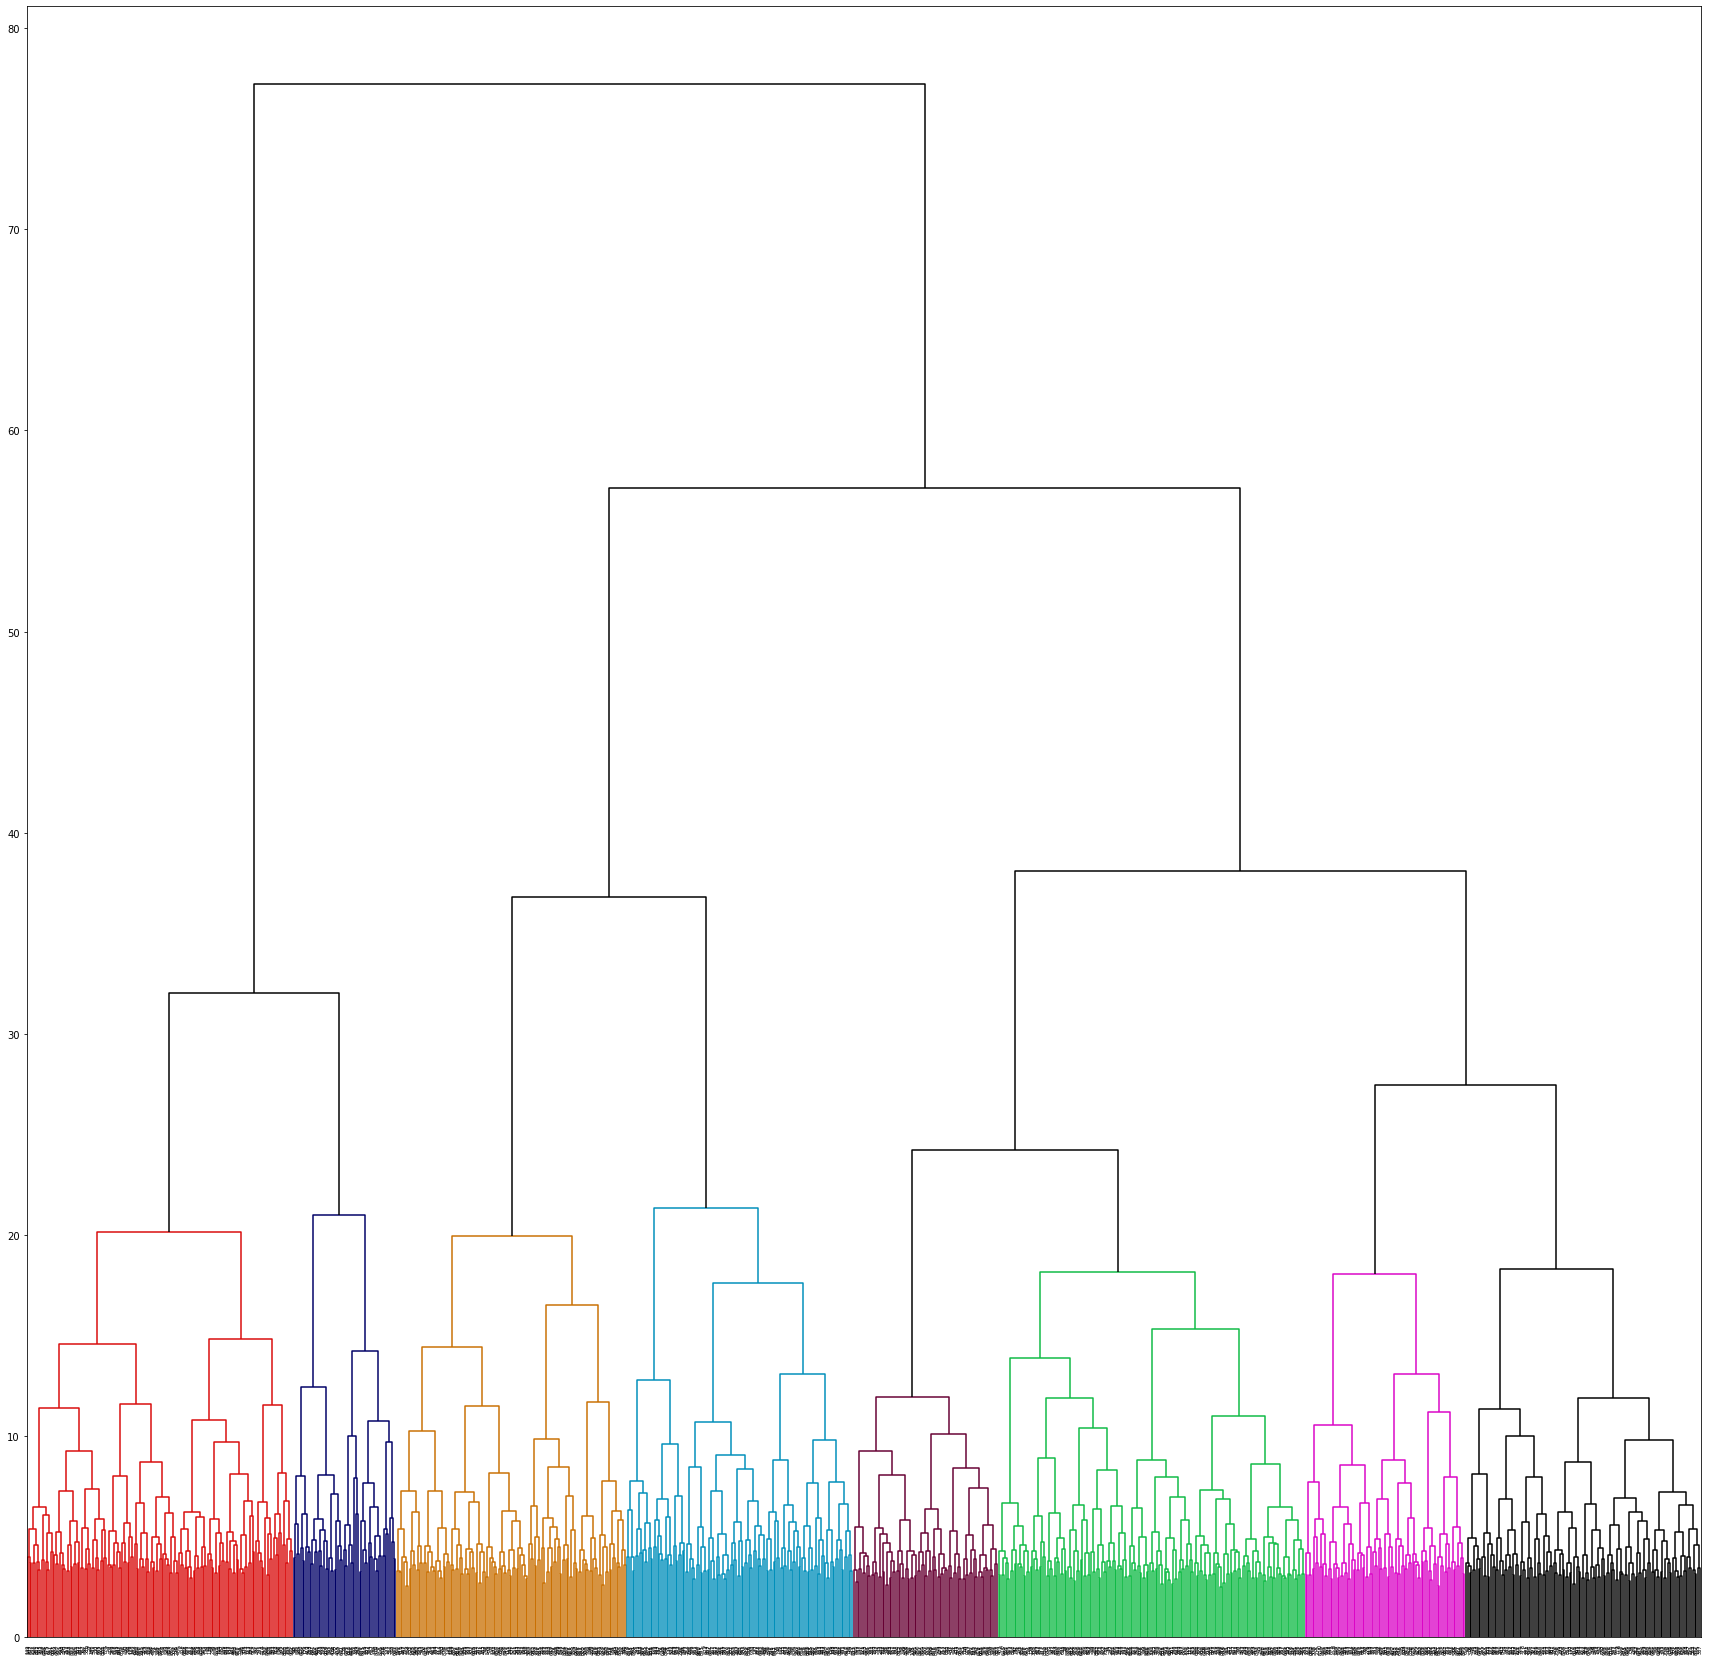

In [32]:
# library import
from scipy.cluster.hierarchy import dendrogram, ward
from scipy.cluster.hierarchy import dendrogram, fcluster, leaves_list, set_link_color_palette
### 데이터 배열 x에 ward 함수를 적용
### scipy의 ward 함수는 병합 군집을 수행할 때 생성된 거리 정보가 담긴 배열을 반환
plt.figure(figsize=(30, 30))

linkage_array = ward(aaa2) 

# print(linkage_array)
# print(len(linkage_array))

set_link_color_palette(["#d90b0b", '#000066','#c97002', '#008fba', "#660033",'#0fba45','#db04c6','#000000'])
dendrogram(linkage_array,color_threshold=22,above_threshold_color="black") 

ax = plt.gca() # get current axes
bounds = ax.get_xbound() # x축 데이터(처음과 끝), 즉 최소/최대값을 가진 (1,2)리스트
plt.savefig('fig0905_2.png')
plt.show()

In [18]:
model1 = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
model1.fit(aaa1)
labels1 = model1.labels_
len(labels1)

938

In [19]:




temp_id,temp_doi = 0,''

#투고 원고 열 정보 추출
temp_title = reviewee.loc[0]['submitter_title']
temp_attribure = reviewee.loc[0]['submitter_attribute']

# 심사자풀 Read
reviewer_attr = pd.read_csv('./reviewer_attribute_937.csv', encoding='latin1')

# 투고원고 dataframe 맨 윗줄 추가
reviewer_attr.loc[-1] = [str(temp_id),temp_doi,temp_title,temp_attribure]
reviewer_attr.index += 1
reviewer_attr.sort_index(inplace=True)

reviewer_attr

,reviewer_orcid,reviewer_title_doi,reviewer_title,reviewer_paper_attribure
0,0,,Diversifying Top-K Results,distance similarities match sequences subseque...
1,36,http://dx.doi.org/10.1145/2588555.2595642.,Fast Database Restarts at Facebook,scuba data memory queries server times upgrade...
2,895,NaN,Loom: Query-aware Partitioning of Online Graphs,graph partitioned queries edges streamed workl...
3,1842,NaN,"Social, Structured and Semantic Search",social documents user rdfs modeled property ur...
4,43,NaN,Fast Approximate Correlation for Massive Time-...,data correlate cache algorithmic computational...
...,...,...,...,...
933,66,NaN,JISC: Adaptive Stream Processing Using Just-In...,states jisc sections queries plans outputs str...
934,200,NaN,Overlap Interval Partition Join,partitioned overlapping relational oip joined ...
935,778,NaN,Verifying Computations with Streaming Interact...,protocol compute verifies query stream keys da...
936,902,NaN,Exact Indexing for Support Vector Machines,rank index based section algorithm functions s...


In [20]:
reviewer_attr['cluster']=labels1
reviewer_attr

,reviewer_orcid,reviewer_title_doi,reviewer_title,reviewer_paper_attribure,cluster
0,0,,Diversifying Top-K Results,distance similarities match sequences subseque...,3
1,36,http://dx.doi.org/10.1145/2588555.2595642.,Fast Database Restarts at Facebook,scuba data memory queries server times upgrade...,4
2,895,NaN,Loom: Query-aware Partitioning of Online Graphs,graph partitioned queries edges streamed workl...,4
3,1842,NaN,"Social, Structured and Semantic Search",social documents user rdfs modeled property ur...,0
4,43,NaN,Fast Approximate Correlation for Massive Time-...,data correlate cache algorithmic computational...,0
...,...,...,...,...,...
933,66,NaN,JISC: Adaptive Stream Processing Using Just-In...,states jisc sections queries plans outputs str...,4
934,200,NaN,Overlap Interval Partition Join,partitioned overlapping relational oip joined ...,4
935,778,NaN,Verifying Computations with Streaming Interact...,protocol compute verifies query stream keys da...,4
936,902,NaN,Exact Indexing for Support Vector Machines,rank index based section algorithm functions s...,6


In [21]:
kmean_reviewer = reviewer_attr[reviewer_attr['cluster'] == reviewer_attr.loc[0]['cluster']]
kmean_reviewer

,reviewer_orcid,reviewer_title_doi,reviewer_title,reviewer_paper_attribure,cluster
0,0,,Diversifying Top-K Results,distance similarities match sequences subseque...,3
73,1808,NaN,Query by Output,querying data ieq differ relate databases exam...,3
155,88,NaN,An Automated System for Internet Pharmacy Veri...,pharmacies drug algorithm problems online legi...,3
169,641,NaN,Privacy-Aware Dynamic Feature Selection,privacy features data server predictability co...,3
172,1811,NaN,Discovering Recurring Patterns in Time Series,pattern periodicity databases mined example ti...,3
181,1291,NaN,Exploring Text Classification for Messy Data: ...,data errors analytically classification texts ...,3
279,2549,NaN,Quick-Motif: An Efficient and Scalable Framewo...,subsequent motifs distance pairs groups times ...,3
360,1728,NaN,Time series anomaly discovery with grammar-bas...,algorithmically compressibility anomalies leng...,3
381,2383,NaN,ALAE: Accelerating Local Alignment with Affine...,sequence alae scores aligning calculating appr...,3
407,2414,NaN,RPM: Representative Pattern Mining for Efficie...,patterns shapelet classes classification algor...,3


In [ ]:
model2 = KMeans(n_clusters=8)
model2.fit(aaa1)
labels2 = model2.labels_
labels2

In [ ]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage

# mat = np.array([[0.0, 2.0, 3.8459253727671276e-16], [2.0, 0.0, 2.0], [3.8459253727671276e-16, 2.0, 0.0]])


dist_mat = aaa1
linkage_matrix = linkage(dist_mat, "single")
dendrogram(linkage_matrix)#, color_threshold=1,show_leaf_counts=True)
fig.set_size_inches(18.5, 10.5)
plt.title=("test")
plt.show()

In [ ]:
# -*- coding: utf-8
head    = lambda arr: arr[0]
tail    = lambda arr: arr[1:]

class Tree:
    parent = None
    def __init__(self, left = None, right = None, dleft = 1, dright = 1):
        self.left  = left
        left.parent = self
        self.right = right
        left.dparent = dleft
        right.parent = self
        self.dleft  = dleft
        right.dparent = dright
        self.dright = dright
    def __repr__(self):
        s = "┬" + ("─" * int(self.dleft))
        if self.left:
            left = repr(self.left).splitlines()
            s += "" + head(left) + "\n"
            for line in tail(left):
                s += "│"  + (" " * int(self.dleft))
                s += line + "\n"
        if self.right:
            right = repr(self.right).splitlines()
            s += "└" + ("─" * int(self.dright))
            s += head(right) + "\n"
            for line in tail(right):
                s += " "  + (" " * int(self.dright))
                s += line + "\n"
        return s
    def __eq__(self, other):
        if other.__class__.__name__ != "Tree":
            return False
        if self.left == other.left:
            return  self.left   == other.left   and \
                    self.right  == other.right  and \
                    self.dleft  == other.dleft  and \
                    self.dright == other.dright
        else:
            return  self.left   == other.right  and \
                    self.right  == other.left   and \
                    self.dleft  == other.dright and \
                    self.dright == other.dleft
    def contains(self, other):
        if id(self) == id(other):
            return True
        else:
            if other.parent == None:
                return False
            else:
                return self.contains(other.parent)
    def distanceTo(self, other):
        if id(self) == id(other):
            return 0
        elif self.contains(other):
            return other.dparent + self.distanceTo(other.parent)
        elif other.contains(self):
            return self.dparent + other.distanceTo(self.parent)
        elif self.parent and other.parent:
            return self.dparent + other.dparent + self.parent.distanceTo(other.parent)
        else:
            raise LookupError("Nodes are not in the same tree!")

class Leaf(Tree):
    def __init__(self, name):
        self.name = name
    def __repr__(self):
        return self.name
    def __eq__(self, other):
        return self.name == other.name

In [ ]:
fig = dm.plot(cmap='Reds', title='Example heatmap')

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


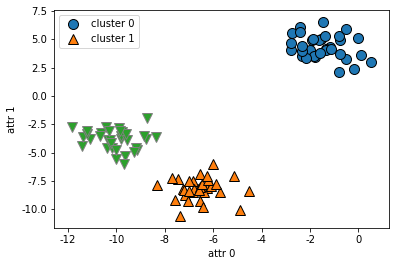

In [77]:
# coding: utf-8
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
import mglearn
import matplotlib.pyplot as plt

# 인위적인 2차원 데이터셋
X, y = make_blobs(random_state=1)

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X)

mglearn.discrete_scatter(X[:, 0], X[:, 1], assignment)

plt.legend(["cluster 0", "cluster 1"], loc="best")
plt.xlabel("attr 0")
plt.ylabel("attr 1")
plt.show()


In [85]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

model = AgglomerativeClustering(n_clusters=2,linkage="ward")
model.fit(aaa)

distance, weight = get_distances(aaa,model)
linkage_matrix = np.column_stack([model.children_, distance, weight]).astype(float)

plt.figure(figsize=(20,20))
dendrogram(linkage_matrix)
plt.show()

KeyError: 415

In [82]:
def get_distances(X,model,mode='l2'):
    distances = []
    weights = []
    children=model.children_
    dims = (X.shape[1],1)
    distCache = {}
    weightCache = {}
    for childs in children:
        c1 = X[childs[0]].reshape(dims)
        c2 = X[childs[1]].reshape(dims)
        c1Dist = 0
        c1W = 1
        c2Dist = 0
        c2W = 1
        if childs[0] in distCache.keys():
            c1Dist = distCache[childs[0]]
            c1W = weightCache[childs[0]]
        if childs[1] in distCache.keys():
            c2Dist = distCache[childs[1]]
            c2W = weightCache[childs[1]]
        d = np.linalg.norm(c1-c2)
        cc = ((c1W*c1)+(c2W*c2))/(c1W+c2W)

        X = np.vstack((X,cc.T))

        newChild_id = X.shape[0]-1

        # How to deal with a higher level cluster merge with lower distance:
        if mode=='l2':  # Increase the higher level cluster size suing an l2 norm
            added_dist = (c1Dist**2+c2Dist**2)**0.5 
            dNew = (d**2 + added_dist**2)**0.5
        elif mode == 'max':  # If the previrous clusters had higher distance, use that one
            dNew = max(d,c1Dist,c2Dist)
        elif mode == 'actual':  # Plot the actual distance.
            dNew = d


        wNew = (c1W + c2W)
        distCache[newChild_id] = dNew
        weightCache[newChild_id] = wNew

        distances.append(dNew)
        weights.append( wNew)
    return distances, weights

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


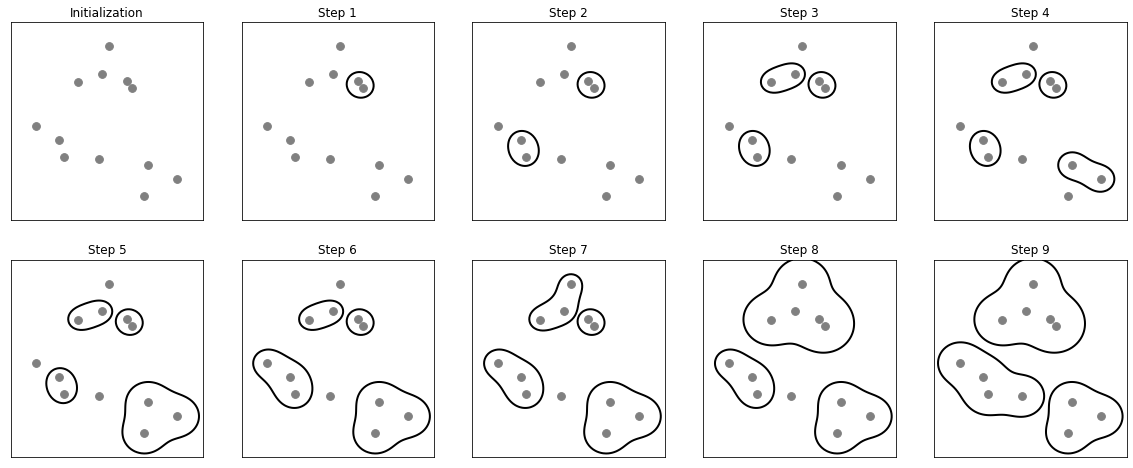

In [76]:
# library import

import mglearn

import matplotlib

import matplotlib.pyplot as plt



# matplotlib 설정

matplotlib.rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False



# 알고리즘 설명 시각화

mglearn.plots.plot_agglomerative_algorithm()

plt.show()

In [ ]:
# library import
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
import numpy as np

# dataset
x, y = make_blobs(random_state=1)

# 모델 생성 및 학습
agg = AgglomerativeClustering(n_clusters=3)
assign = agg.fit_predict(x)

# 배열 x 오른쪽에 열 한개 추가
a = assign.reshape(-1, 1)
x1 = np.hstack([x, a])

# 각 클래스별로 데이터 추출
x_0 = x1[x1[:, 2]==0, :]
x_1 = x1[x1[:, 2]==1, :]
x_2 = x1[x1[:, 2]==2, :]

# 시각화
plt.scatter(x_0[:, 0], x_0[:, 1], cmap=mglearn.cm3)
plt.scatter(x_1[:, 0], x_1[:, 1], cmap=mglearn.cm3)
plt.scatter(x_2[:, 0], x_2[:, 1], cmap=mglearn.cm3)
plt.legend(['cluster 0', 'cluster 1', 'cluster 2'], loc=2)
plt.show()

In [75]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='average')
cluster.fit_predict(temp1)

# pd.value_counts(pd.Series(cluster.labels_))

cluster

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=7,
                        pooling_func='deprecated')

TypeError: only integer scalar arrays can be converted to a scalar index

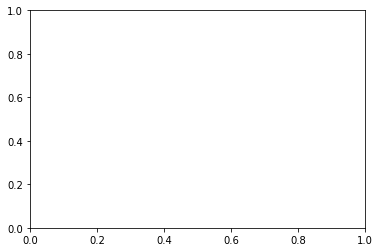

In [72]:
# coding: utf-8

from sklearn.datasets import make_blobs

from sklearn.cluster import AgglomerativeClustering

import mglearn

import matplotlib.pyplot as plt



# 인위적인 2차원 데이터셋

X=aaa

agg = AgglomerativeClustering(n_clusters=3)

assignment = agg.fit_predict(X)



mglearn.discrete_scatter(X[:, 0], X[:, 1], assignment)

plt.legend(["cluster 0", "cluster 1"], loc="best")
plt.xlabel("attr 0")
plt.ylabel("attr 1")

plt.show()

In [58]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=7)
x_names = [x for x in total_activity.columns if x not in ['acc_id']]
km.fit(total_activity[x_names])
pd.value_counts(pd.Series(km.labels_))


NameError: name 'total_activity' is not defined

In [36]:
from sklearn.metrics.pairwise import euclidean_distances
X = [[0, 1], [1, 1]]
# distance between rows of X
euclidean_distances(X, X)

# get distance to origin
euclidean_distances(X, [[0, 0]])


array([[1.        ],
       [1.41421356]])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances



In [23]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
X[:,0]


array([ 8.36856841e-01, -1.41365810e+00,  1.15521298e+00, -1.01861632e+00,
        1.27135141e+00,  3.43761754e+00, -1.80822253e+00,  1.41372442e+00,
       -2.04932168e-01, -7.11099611e-01, -1.71237268e+00, -2.67000792e+00,
        1.24258802e+00, -2.22783649e+00,  1.45513831e+00,  4.53791789e-01,
        1.06923853e+00,  2.56936589e+00, -1.06690610e+00, -1.07859101e+00,
        2.71506328e+00,  1.77710994e+00,  7.34363910e-01, -1.99648151e+00,
       -1.91828017e+00, -5.55523811e-01,  1.69747910e+00,  5.94762432e-01,
       -2.88024255e+00,  1.86725632e-01, -5.13333436e-01, -2.05701103e+00,
        1.87271752e+00, -1.13121396e+00, -1.64428957e+00, -2.41933824e+00,
       -2.01606928e+00, -2.62142780e+00, -2.20299950e+00,  1.66382237e+00,
        6.69786996e-01, -1.98539037e+00, -4.74920358e-02,  1.54462126e+00,
       -1.70200643e+00, -1.02192525e+00, -1.37842552e+00, -1.55220688e+00,
       -1.47904303e+00,  1.98894313e+00, -1.94972418e+00,  2.45509737e+00,
       -8.94327882e-01,  

In [20]:
max(a)

3

0번째
[[0.2486841  0.2486841  0.2486841  ... 0.22500387 0.22500387 0.2486841 ]
 [0.2202385  0.2434172  0.2202385  ... 0.20379294 0.2434172  0.15743552]
 [0.26458961 0.26458961 0.17112925 ... 0.20765313 0.17112925 0.17112925]
 ...
 [0.25622464 0.25622464 0.25622464 ... 0.15364395 0.23182638 0.08574023]
 [0.24552026 0.24552026 0.24552026 ... 0.20555365 0.15879572 0.17328642]
 [0.24932045 0.24932045 0.24932045 ... 0.17596856 0.19566971 0.16125357]]


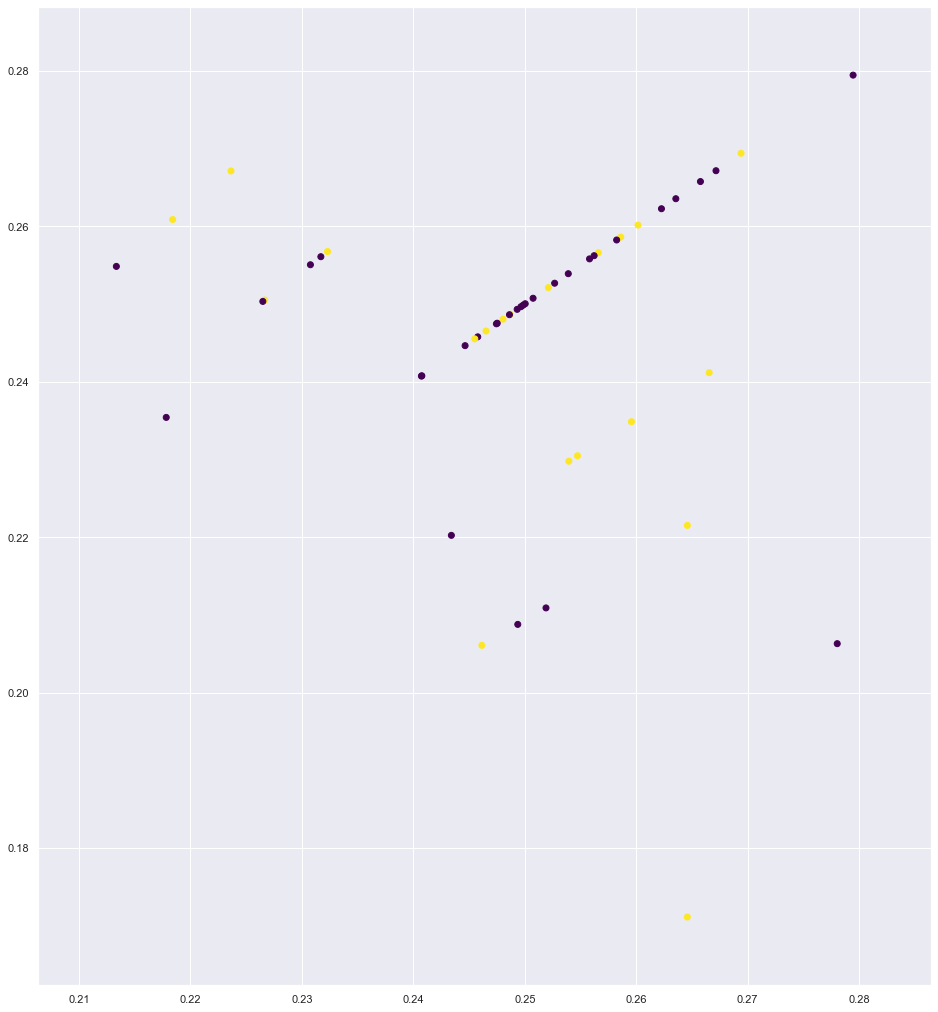

In [34]:
#-*- coding:utf-8 -*-

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

#전문성 검사 함수 정의부
#키워드 매개변수(입력csv path, 투고원고 DataFrame, i번째 투고 원고, 추천할 심사자 수, 실루엣값 계산 범위 지정)
def professionalism(path,extractive_keyword_result,reviewee_index,top_limit,silhouette_range=25):
    
    reviewee=extractive_keyword_result
    index=reviewee_index
    top=top_limit
    
    temp_id,temp_doi = 0,''
    
    temp_title = reviewee.loc[index]['submitter_title']
    temp_attribure = reviewee.loc[index]['submitter_attribute']

    reviewer_attr = pd.read_csv(path, encoding='latin1')
    reviewer_attr.loc[-1]=[str(temp_id),temp_doi,temp_title,temp_attribure]
    reviewer_attr.index += 1
    reviewer_attr.sort_index(inplace=True)
    reviewer=reviewer_attr['reviewer_paper_attribure']
    
    #------------------------------------------------
    
    aaa=[]
    for i in range(51):
        a=(reviewer[i].split(' '))
        b=a[:20]
        temp=''
        for j in range(20):
            temp += (str(b[j]) + ' ')
        aaa.append(temp[:-1])
    
    # -----------------------------------------------
    vectorizer = TfidfVectorizer(stop_words='english')
    
    Y = vectorizer.fit_transform(aaa)
    
#     print('속성집합 결과')
#     print(Y)#벡터값 조회 결과
#     print("---------------------------------------")
    
    a0=[]
    
    for i in range(51):
        a1=Y[i].tocoo()
        a2=(a1.data).tolist()
    
    for i in range(51):
        
        a1=Y[i].tocoo()
        a2=((a1.data).tolist())
        a3=np.array(a2)
        a0.append(a3)
    
    aaa=np.array(a0)
    
#     print('속성집합 List화 결과')
#     print(aaa)
#     print("---------------------------------------")
    
    X = StandardScaler().fit_transform(aaa)
    
    colors = plt.cm.tab10(np.arange(20, dtype=int))
    plt.figure(figsize=(16, 18))
    
    model = SpectralClustering(n_clusters=2, affinity="nearest_neighbors")
    cluster_labels = model.fit_predict(X)
    
#     for i in range(3):
#         model = SpectralClustering(n_clusters=i + 2, affinity="nearest_neighbors")
#         cluster_labels = model.fit_predict(X)
        
#         sample_silhouette_values = silhouette_samples(X, cluster_labels)
#         silhouette_avg = sample_silhouette_values.mean()
        
#         plt.subplot(3, 2, 2 * i + 1)
#         plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[cluster_labels])
        
#         plt.xlim(-2.5, 2.5)
#         plt.ylim(-2.5, 2.5)
        
#         plt.xticks(())
#         plt.yticks(())
        
#         plt.title('군집 수 : {}' .format(i + 2))
        
#     plt.tight_layout()
#     plt.show()

    print(aaa)
    centers, labels = find_clusters(aaa, 2)
    plt.scatter(aaa[:],aaa[:,2], c=labels , cmap='viridis')
    
    #return type : pandas.dataframe
    return professionalism

#전문성검사
#키워드 매개변수(입력csv path, 투고원고 DataFrame, i번째 투고 원고, 추천할 심사자 수, 실루엣값 계산 범위 지정)


for i in range(1):
    try :
        print(str(i)+'번째')
        professionalism(path='../../reviewer_pool/100/reviewer_attribute_6.csv',
                             extractive_keyword_result=reviewee,
                             reviewee_index=i,
                             top_limit=10,
                             silhouette_range=25)
    except ValueError:
        print("\n")
        pass
#return type : pandas.dataframe

# reviewer


array([[ 9.93342581e+00, -1.55235644e+00],
       [-5.71099336e-01,  8.13306058e+00],
       [ 5.59529363e-01,  4.21400660e+00],
       [ 8.46449996e+00, -2.78811366e+00],
       [-1.23065895e+00,  2.84821990e+00],
       [-1.56387985e+00,  2.85349910e+00],
       [ 1.36155806e+00,  1.36638252e+00],
       [ 1.65991049e+00,  3.56289184e+00],
       [ 2.95195825e+00, -3.44327355e-01],
       [-1.07999075e+00,  7.23958585e+00],
       [ 9.14153059e+00, -2.98159160e+00],
       [ 8.50544171e+00, -2.68242835e+00],
       [ 1.87271752e+00,  4.18069237e+00],
       [-9.73806411e-01,  7.25669281e+00],
       [-1.27567815e+00,  7.96776461e+00],
       [ 7.89338559e-01,  4.33748653e+00],
       [ 4.43598630e-01,  3.11530945e+00],
       [ 2.03169783e+00,  1.96807561e-01],
       [ 9.40134324e+00, -3.05631382e+00],
       [-2.58043836e+00,  3.18844294e+00],
       [ 2.01432256e+00,  1.92566929e+00],
       [-1.07859101e+00,  2.20451529e+00],
       [ 1.10123507e+00,  4.88977075e+00],
       [ 9.

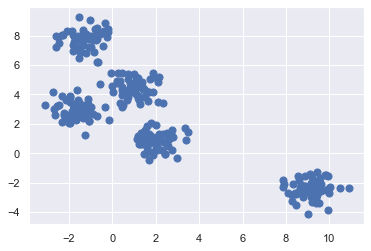

In [27]:
from sklearn.metrics import pairwise_distances_argmin

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

from sklearn.datasets.samples_generator import make_blobs


X, y_true = make_blobs(n_samples=300, centers=5, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);


# def find_clusters(X, n_clusters, rseed=2):
#     # 1. Randomly choose clusters
#     rng = np.random.RandomState(rseed)
#     i = rng.permutation(X.shape[0])[:n_clusters]
#     centers = X[i]
    
#     while True:
#         # 2a. Assign labels based on closest center
#         labels = pairwise_distances_argmin(X, centers)
        
#         # 2b. Find new centers from means of points
#         new_centers = np.array([X[labels == i].mean(0)
#                                 for i in range(n_clusters)])
        
#         # 2c. Check for convergence
#         if np.all(centers == new_centers):
#             break
#         centers = new_centers
    
#     return centers, labels

# centers, labels = find_clusters(X, 5)
# plt.scatter(X[:, 0], X[:, 1], c=labels,
#             s=50, cmap='viridis')

X

In [2]:
import pandas as pd

#전처리 함수 정의부
def remove_string_special_characters(s):
    
    stripped = re.sub('[^a-zA-z\s]', '', s)
    
    stripped = re.sub('_', '', stripped)
    
    stripped = re.sub('\s+', ' ', stripped)
    
    stripped = stripped.strip()
    
    if stripped != '':
        return stripped.lower()
    

#속성집합 추출 함수 정의부
#키워드 매개변수(입력csv path, 속선집합 포함 출력csv path, 추출할 단어 수)
def extractive_keyword(path,database_update_path,extract_word_num=25):
    
    reviewee = pd.read_csv(path, encoding='latin1')
    count,temp = len(reviewee),[]

    for i in range(count):
        
        temp_intro = reviewee['intro'][i]

        textrank_text = ''

        for c in (keywords(temp_intro, words=extract_word_num, lemmatize=True).split('\n')):
            
            textrank_text += (c+ " ")

        temp.append(textrank_text)
    
    reviewee['reviewer_paper_attribure']=temp
    reviewee.iloc[:,:].to_csv(database_update_path)
    
    #return type : pandas.dataframe
    return reviewee

reviewee=extractive_keyword(path='./reviewer_attribute_0613.csv',
                                database_update_path='./reviewer_attribute_4_0613.csv',
                                extract_word_num=25)


FileNotFoundError: [Errno 2] File b'./reviewer_attribute_0613.csv' does not exist: b'./reviewer_attribute_0613.csv'